In [1]:
# #%pip install -qU langchain-unstructured
# !pip install -qU "langchain-chroma>=0.1.2"
# import numpy as np
# import pandas as pd
# import bs4
import chromadb
from langchain import hub
from langchain_chroma import Chroma
# from langchain_community.document_loaders import WebBaseLoader
from uuid import uuid4
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings
# from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import fitz
import pickle
from langchain_openai import ChatOpenAI
import getpass
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core import Document as llamaDoc
from langchain.retrievers import BM25Retriever, EnsembleRetriever


In [2]:

openai_key = getpass.getpass("Enter API key for OpenAI: ")
os.environ["OPENAI_API_KEY"] = openai_key

In [3]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
llm = ChatOpenAI(model="gpt-4o-mini")

### Vector database

In [4]:
def build_vector_db(persist_directory, collection_name, file_path, doc_chunks):
    '''Build a vector database with ChromaDB'''

    persistent_client = chromadb.PersistentClient()
    collection = persistent_client.get_or_create_collection(collection_name)

    vector_store = Chroma(
        client=persistent_client,
        collection_name=collection_name,
        embedding_function=embeddings,
        persist_directory=persist_directory
    )

    # Loading the pdf document
    docs = fitz.open(file_path)

    # Reading each page and splitting into chunks
    documents = []

    idx = 0
    for i,page in enumerate(docs):
        page_text = page.get_text()
        page_number = i
        
        splitter = SentenceSplitter(chunk_size= 256, chunk_overlap=20)

        nodes = splitter.get_nodes_from_documents(
            [llamaDoc(text=page_text)], show_progress=False)

        for j,node in enumerate(nodes):

            idx += 1
            documents.append(Document(
                page_content=node.text,
                metadata={"source": "DSM5",'page':page_number,'chunk':j},
                id=idx,
            ))

    with open(doc_chunks, 'wb') as f: 
        pickle.dump(documents, f)


In [5]:
persist_directory = '../data/chroma'
collection_name = "DSM5_collection"
file_path = '../data/DSM5.pdf'
doc_chunks = '../data/DSM_chunks'

## Uncomment the line below to build the vector database
# build_vector_db(persist_directory, collection_name, file_path, doc_chunks)

In [6]:
vector_store = Chroma(persist_directory=persist_directory, embedding_function=embeddings)
with open(doc_chunks, 'rb') as f: 
    documents = pickle.load(f) 

### Tool

In [7]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""

    vector_retriever = vector_store.as_retriever(
        search_type="similarity",
        search_kwargs={'k': 4})

    keyword_retriever = BM25Retriever.from_documents(documents)
    keyword_retriever.k =  3

    retriever = EnsembleRetriever(
                                retrievers=[vector_retriever,keyword_retriever],
                                weights=[0.7, 0.3])


    # retrieved_docs = vector_store.similarity_search(query, k=2)
    retrieved_docs = retriever.invoke(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [8]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(MessagesState)

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [9]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

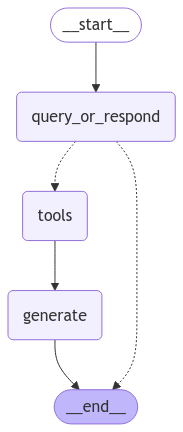

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
input_message = "What is ADHD?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    ):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is ADHD?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_8SV5zNUgL8Qvl1g647fsF4LX)
 Call ID: call_8SV5zNUgL8Qvl1g647fsF4LX
  Args:
    query: What is ADHD?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'DSM5', 'page': 796, 'chunk': 2}
Content: 3.
What troubles you most about your prob-
lem?
CULTURAL PERCEPTIONS OF CAUSE, CONTEXT, AND SUPPORT
CAUSES
(Explanatory Model, Social Network, Older Adults)
This question indicates the meaning of the condition 
for the individual, which may be relevant for clin-
ical care.
4.
Why do you think this is happening to 
you? What do you think are the causes of 
your [PROBLEM]?
Note that individuals may identify multiple causes, 
depending on the facet of the problem they are con-
sidering.
PROMPT FURTHER IF REQUIRED:
Some people may expl

### Chat history management

In [12]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

### Chat

In [13]:
# Conversation turn 1
input_message = "What is ADHD?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config
    ):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is ADHD?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_76e2BkxNNzdGGoZl9mgn3u4O)
 Call ID: call_76e2BkxNNzdGGoZl9mgn3u4O
  Args:
    query: What is ADHD?
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'DSM5', 'page': 796, 'chunk': 2}
Content: 3.
What troubles you most about your prob-
lem?
CULTURAL PERCEPTIONS OF CAUSE, CONTEXT, AND SUPPORT
CAUSES
(Explanatory Model, Social Network, Older Adults)
This question indicates the meaning of the condition 
for the individual, which may be relevant for clin-
ical care.
4.
Why do you think this is happening to 
you? What do you think are the causes of 
your [PROBLEM]?
Note that individuals may identify multiple causes, 
depending on the facet of the problem they are con-
sidering.
PROMPT FURTHER IF REQUIRED:
Some people may expl

In [14]:
# Conversation turn 2
input_message = "How can I diagnose it in one of my clients?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
    ):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

How can I diagnose it in one of my clients?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_bWQJNd7gWtjC6BQqsKjUrHr5)
 Call ID: call_bWQJNd7gWtjC6BQqsKjUrHr5
  Args:
    query: how to diagnose ADHD in clients
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'DSM5', 'page': 477, 'chunk': 2}
Content: A “desire discrepancy,” in which a woman has lower desire for sexual activ-
ity than her partner, is not sufficient to diagnose female sexual interest/arousal disorder.
In order for the criteria for the disorder to be met, there must be absence or reduced fre-
quency or intensity of at least three of six indicators (Criterion A) for a minimum duration
of approximately 6 months (Criterion B). There may be different symptom profiles across
women, as well as variability in how sexual int